In [15]:
import copy
# ------------------------------
import pandas as pd
import numpy as np
# ------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# ------------------------------
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from sklearn.ensemble import RandomForestClassifier
from  sklearn.model_selection import GridSearchCV
import scipy.stats as st
from  sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Описание выбранного набора данных и решаемая задача

Тема курсовой работы **"Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения"**

Задача: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи курсовой работы необходимо определить решаему задачу в области машщинного обучения и данные её характеризующие, выбрать модель в равной степени хорошо подходящую для решения обеих задач.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "одобрить кредит" или "не одобрить кредит" по некторому набору признаков. Набор данных взять с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), ниже приведено подробное описание набора данных.

Набор данных представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30**-59DaysPastDueNotWorse - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому  вдальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.

В данной работе для оптимизации выбрана модель дерева решений по ряду причин:
- Легкость настройки - ряд ключевых гипперпараметров модели представляют собой целочисленные значения, что значительно облегчит применение байесовской оптимизации;
- Хороший baseline - построенная и оптимизированная модель послужит хорошей основой для дальнейшей работы и улучшения результатов;

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [3]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe().T)

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Визуализация данных

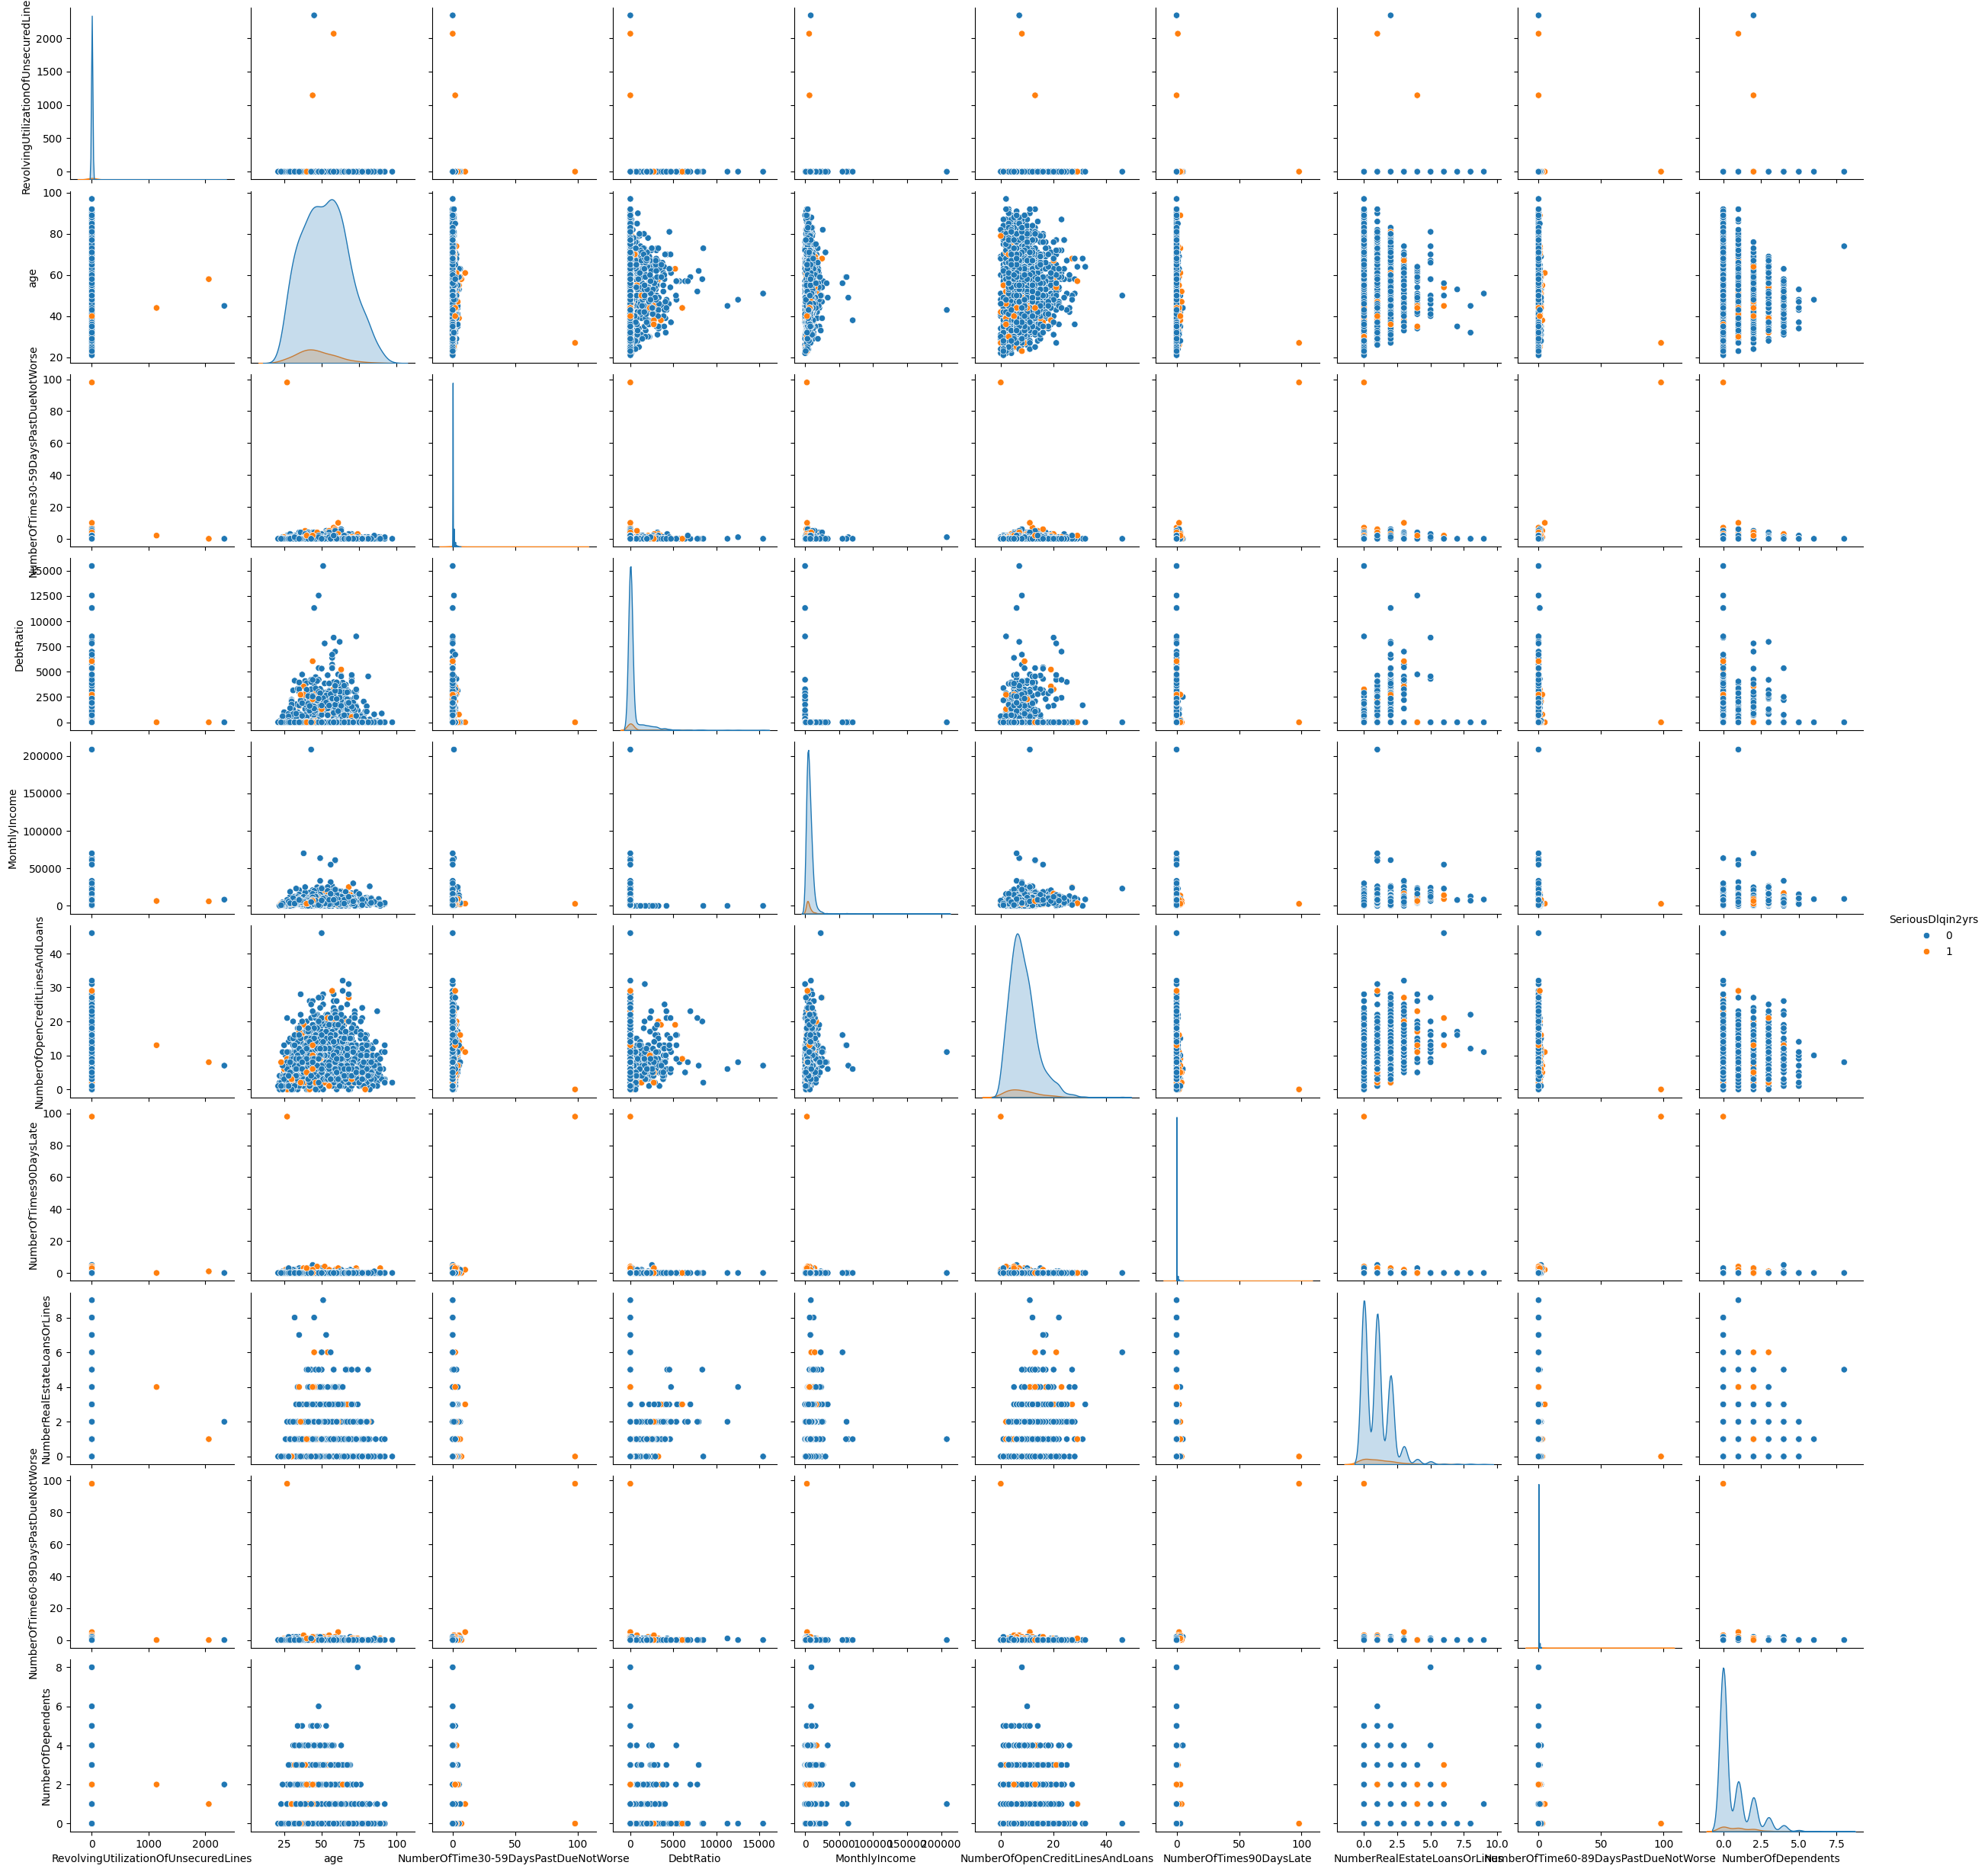

In [4]:
sns.pairplot(data.iloc[0:2000,:], hue= 'SeriousDlqin2yrs')

# Описательный анализ данных 

## Решение проблемы пропусков в наборе данных

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки. Значение пропусков будут восстановлены с помощью интерполяции.

In [10]:
nan_index_MonthlyIncome = data[data["MonthlyIncome"].isna() == True].index
nan_index_NumberOfDependents = data[data["NumberOfDependents"].isna() == True].index
data["MonthlyIncome"] = data["MonthlyIncome"].interpolate()
data["NumberOfDependents"] = data["NumberOfDependents"].interpolate()

## Поиск и удаление выбросов

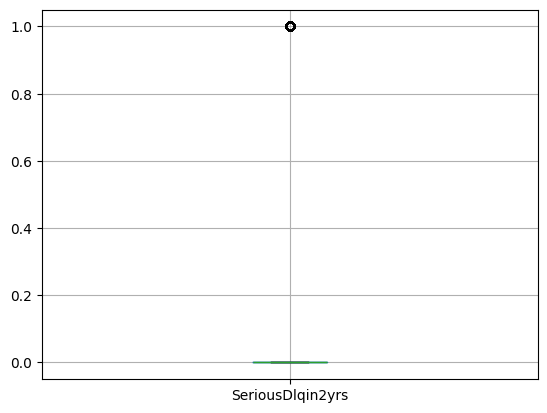

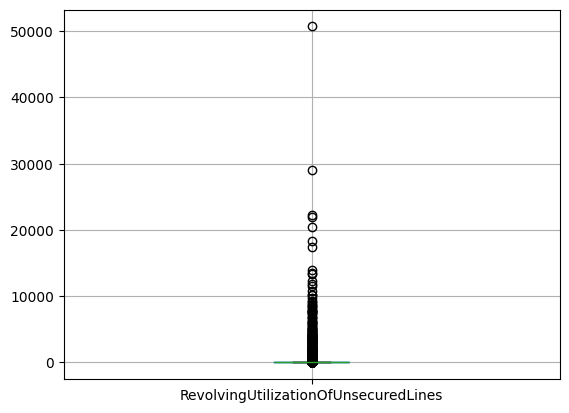

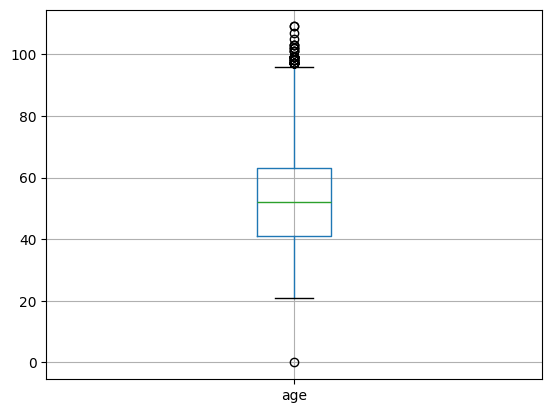

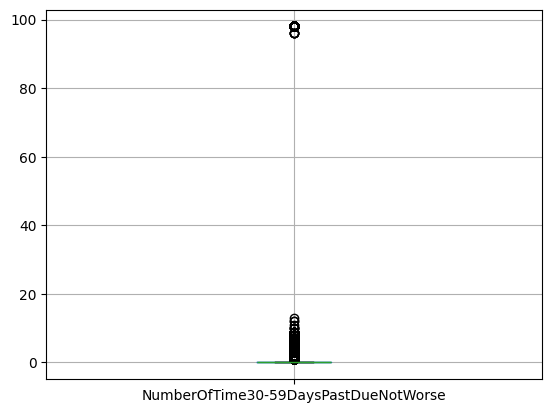

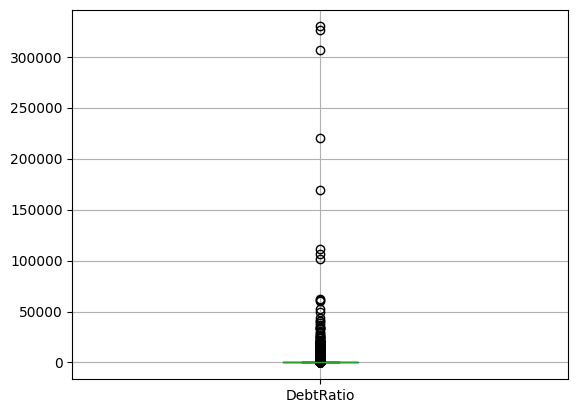

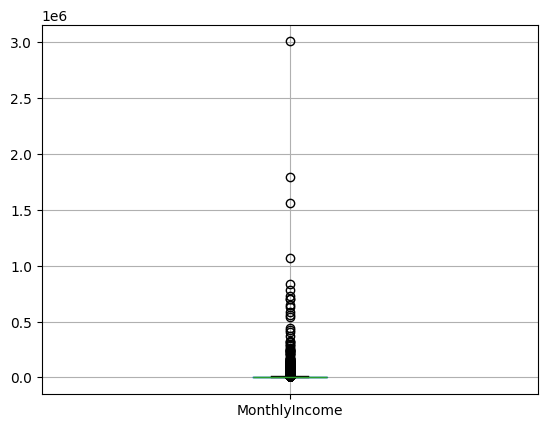

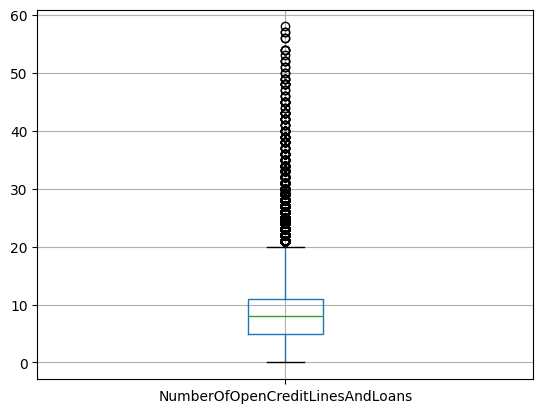

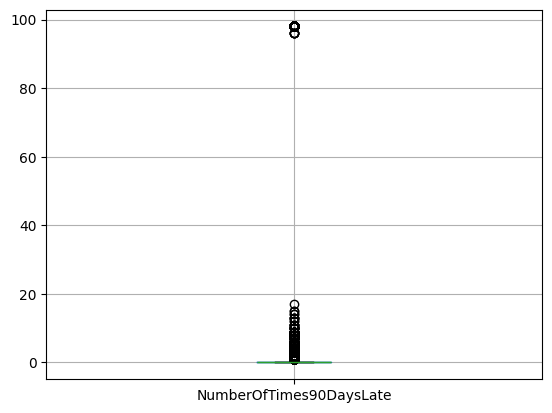

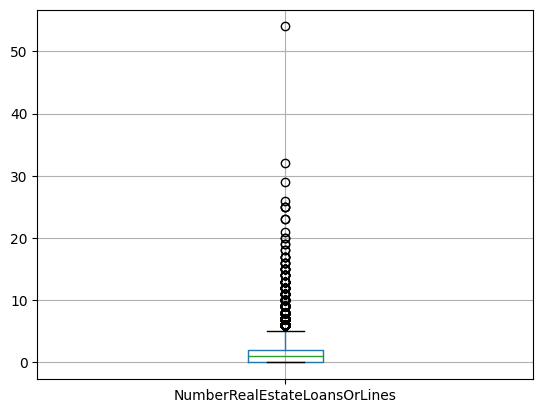

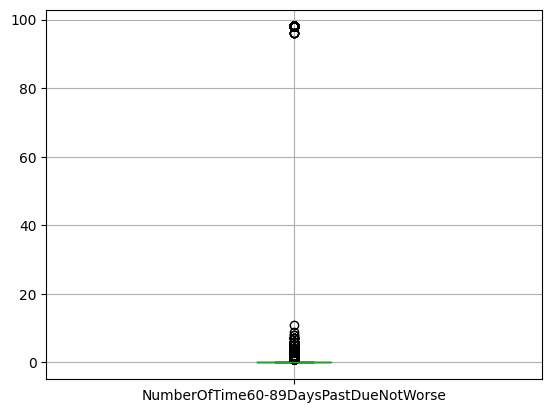

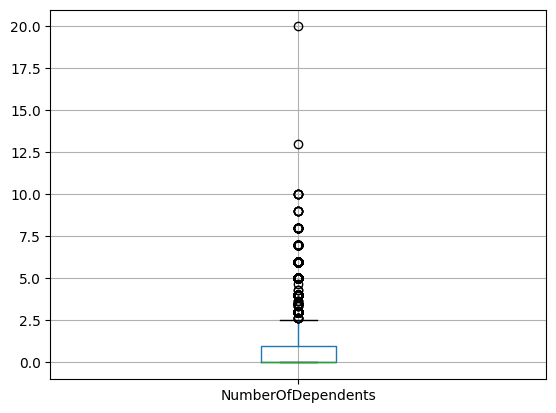

In [6]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Сначала будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 22 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 22 лет.

Другие заменяю на медиану. Кроме NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, так как, в основном, они равны нулю и выбросы в этих признаках несут важную инфорацию. 

In [4]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 22
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

In [5]:
another_columns = set(data.columns) - set(["age", "SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])
for column in another_columns:
    Q1, Q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    IRQ = Q3 - Q1 
    topline = Q3 + IRQ * 1.5 
    downline = Q1 - IRQ * 1.5 
    median = data[column].interpolate()
    data.loc[data[data[column] > topline].index, column] = median
    data.loc[data[data[column] < downline].index, column] = median

## Визуализация распределения

Из-за огромного количества данных построить распределения для каждого атрибута по всем данным слишком затратно по времени. Поэтому использую train_test_split из sklearn для создания репрезентативной подвыборки. Обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

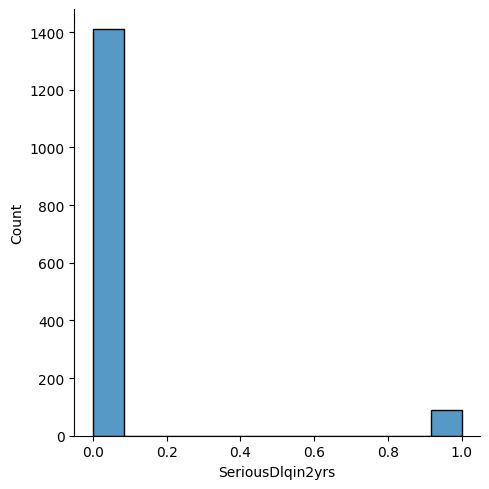

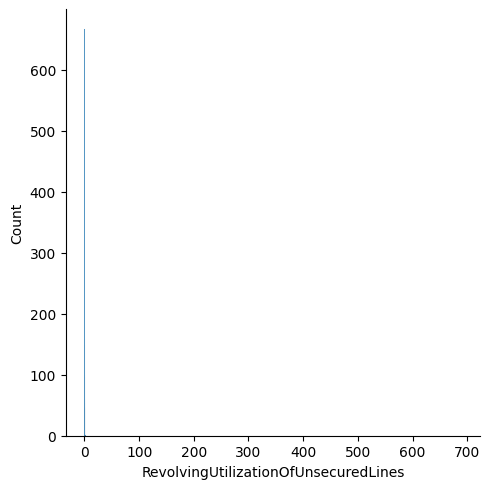

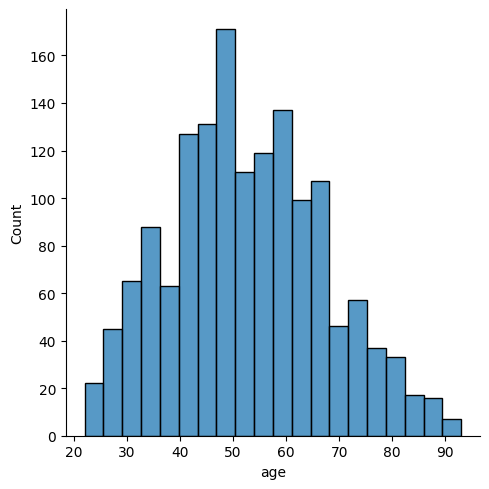

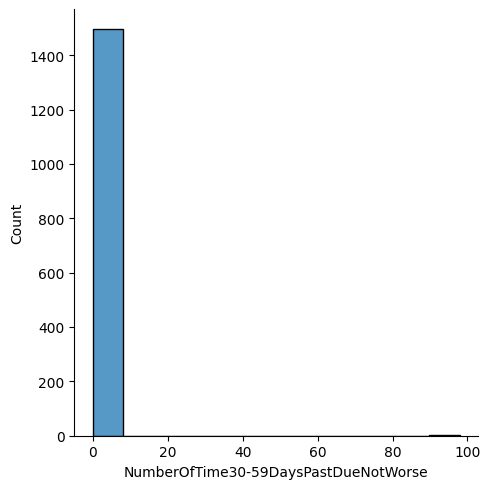

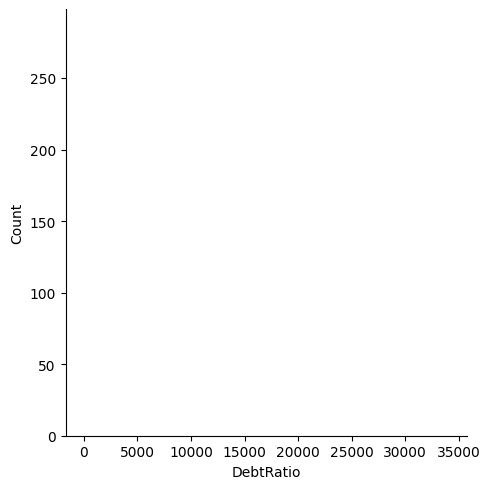

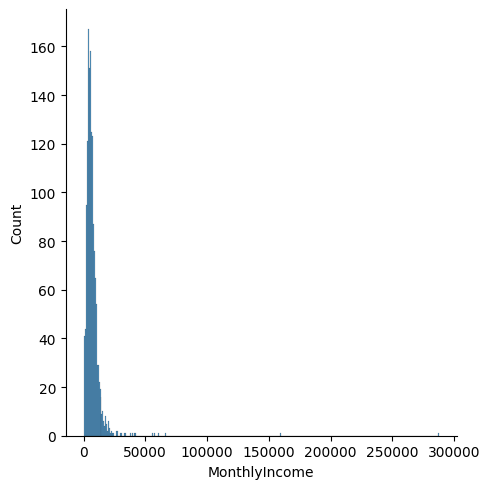

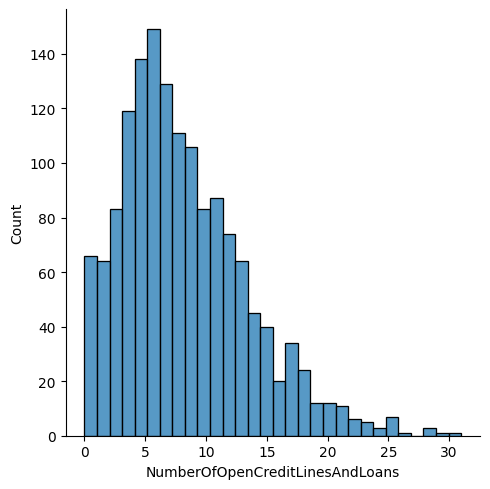

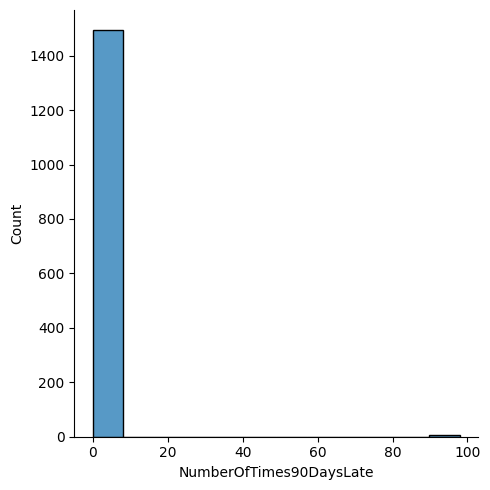

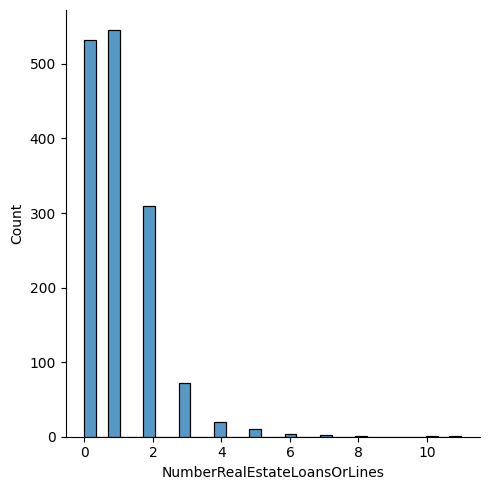

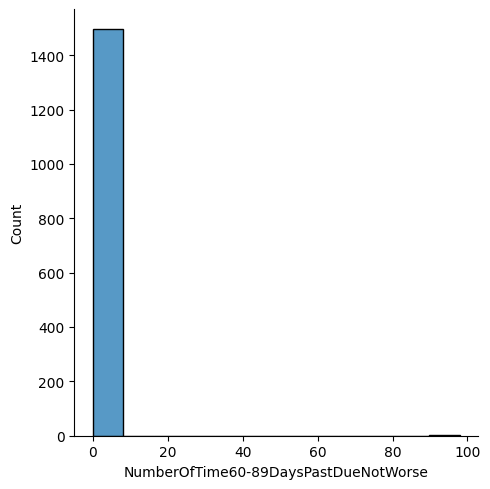

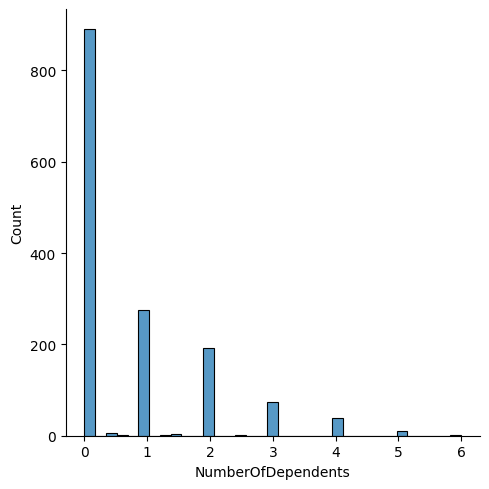

In [9]:
import seaborn as sns
from sklearn.model_selection import train_test_split

for column in data.columns:
    data_col, _ = train_test_split(data[column], test_size=0.01)
    display(sns.displot(_))

## Корреляционная матрица

In [10]:
def draw_cov(data):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix')
    sns.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

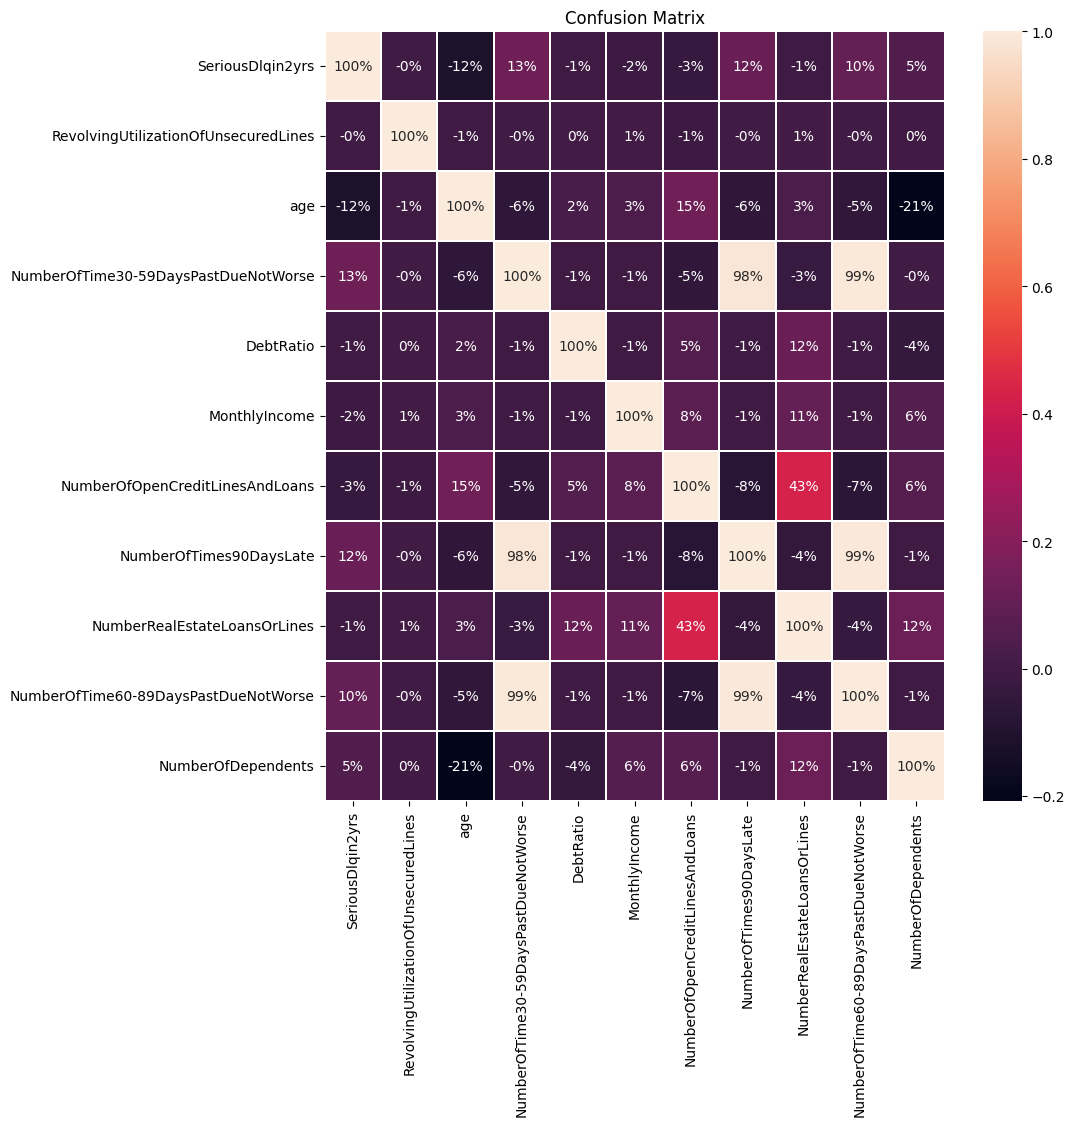

In [11]:
draw_cov(data)

# Выявим наиболее информативные атрибуты

Эта часть анализа выполнена с помощью случайного леса - обученный на всей выборке, модель покажет информативность и вариативность каждого отдельного атрибута. 

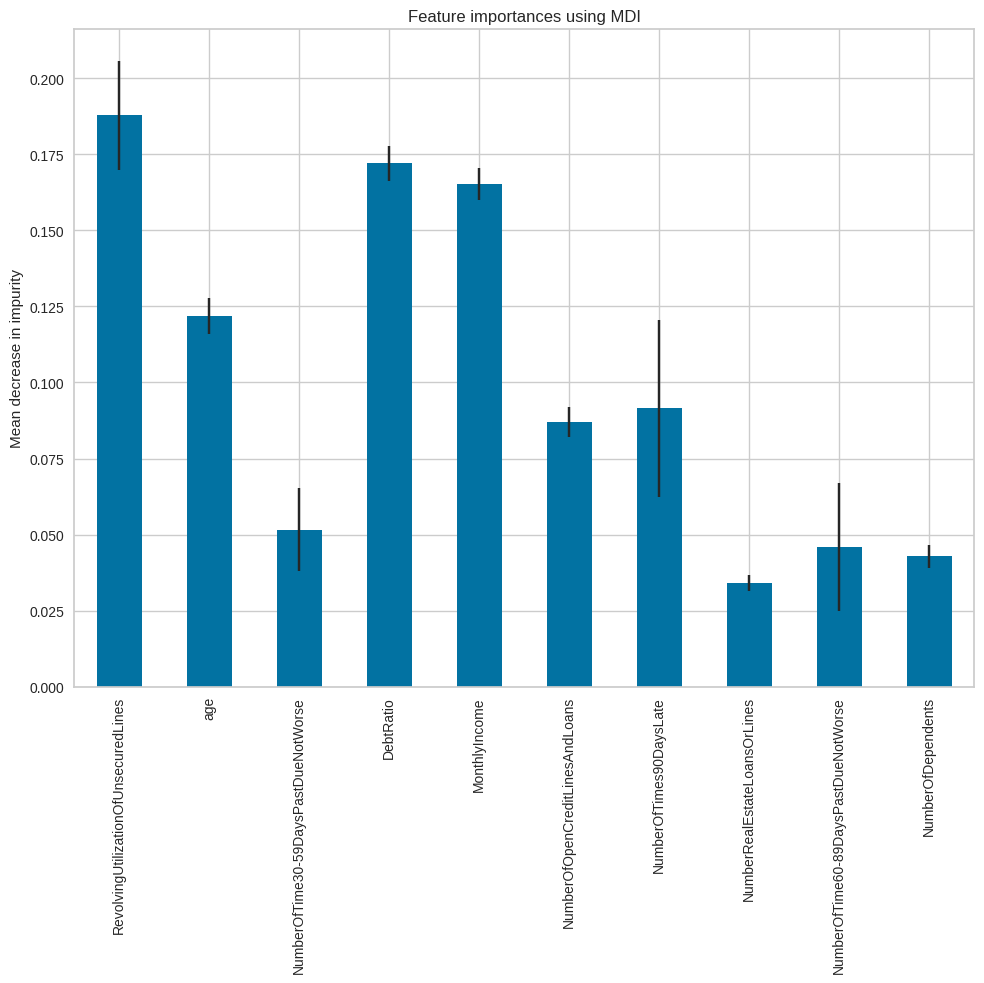

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(np.arange(0, 10, 1), labels=X.columns.tolist())
fig.tight_layout()

## Продолжение анализа важности атрибутов

Анализ атрибутов с помощью случайного леса ничего существенного не дал, поэтому решено применить PCA (метод главных компонент).

Как видно, 6 первых атрибутов PCA объясняют ~90% всей дисперсии данных! 

Общая объясненная дисперсия 0.8694078075536401


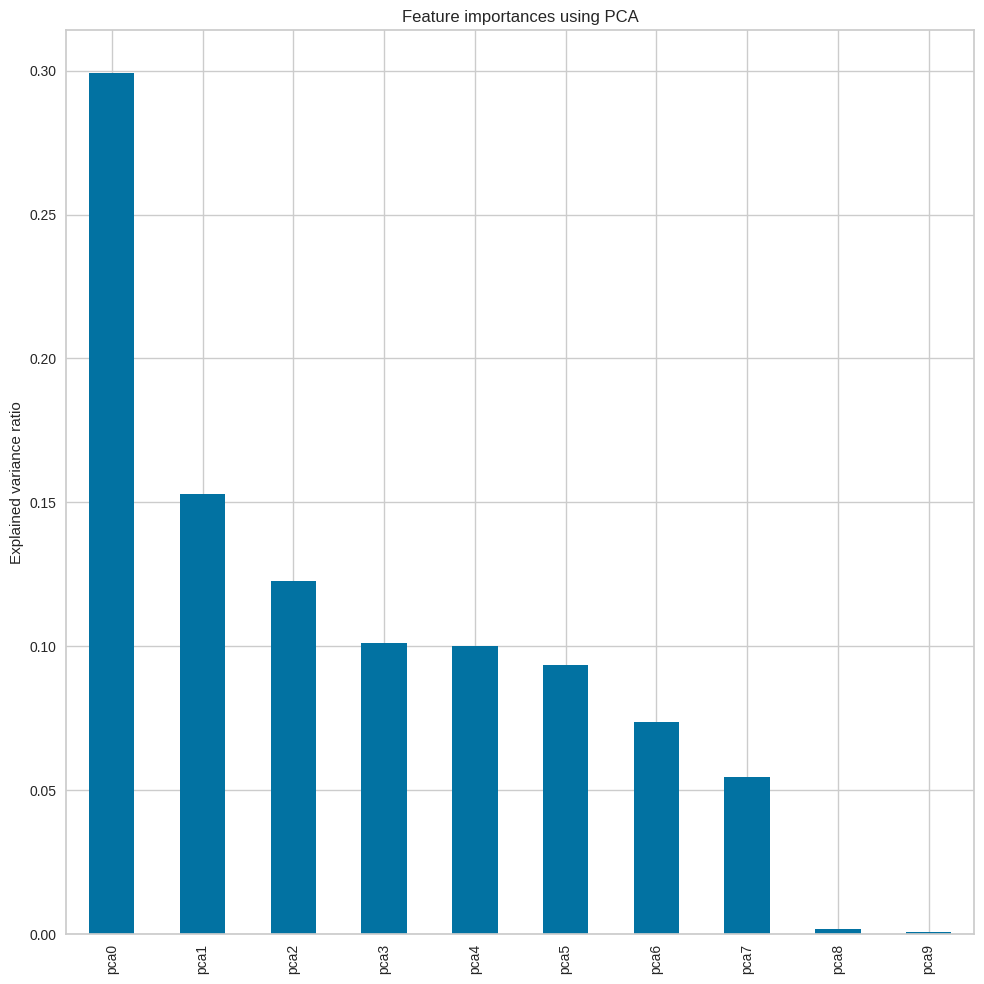

In [12]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

pca_machine = PCA(n_components=min(X.shape[0], X.shape[1]), svd_solver="covariance_eigh")

pca_X = pca_machine.fit(pd.DataFrame(scaled_X, columns=X.columns.values))

pca_importances = pd.Series(pca_X.explained_variance_ratio_, index=pca_X.get_feature_names_out())

fig, ax = plt.subplots(figsize=(10,10))
pca_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using PCA")
ax.set_ylabel("Explained variance ratio")
ax.set_xticks(np.arange(0, 10, 1), labels=pca_X.get_feature_names_out())
fig.tight_layout()

most_explainde_pca_X = pca_X.explained_variance_ratio_[:6]
print(f"Общая объясненная дисперсия {most_explainde_pca_X.sum()}")

transformed_X = pca_machine.transform(pd.DataFrame(scaled_X, columns=X.columns.values))

# Разделение данных на тестовую и обучающую выборки

Из-за огромного количества данных для теста достаточно 0.01 от всего массива данных

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

X, y = transformed_X, data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

# Подбор моделей

## DecisionTreeClassifier

In [16]:
from sklearn.tree import DecisionTreeClassifier

pipline = make_pipeline(StandardScaler(), DecisionTreeClassifier())
model_DT = pipline.fit(X_train, y_train)
print(f"ROC_AUC: {roc_auc_score(y_test, model_DT.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_DT, X, y, scoring="roc_auc"))}")

ROC_AUC: 0.5998507746128356
 Cross validation score: 0.5992780351002589


## GaussianNB

In [17]:
from sklearn.naive_bayes import GaussianNB

pipline = make_pipeline(GaussianNB())
model_GNB = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_GNB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GNB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.652112574002958
 Cross validation score: 0.8001764693865621


## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression 

pipline = make_pipeline(LogisticRegression())
model_LogReg = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_LogReg.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5179590219793699
 Cross validation score: 0.6981047558289312


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

pipline = make_pipeline(RandomForestClassifier())
model_RF = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_RF.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_RF, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5892558194822717
 Cross validation score: 0.7992582264265602


## Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

pipline = make_pipeline(GradientBoostingClassifier())
model_GB = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_GB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5751239243198548
 Cross validation score: 0.8306632699576214


## KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

pipline = make_pipeline(KNeighborsClassifier())
model_KNN = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_KNN.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_KNN, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5585006376768766
 Cross validation score: 0.6895158695031907


## Neural Network

Наиболее перспективная модель

In [ ]:
from sklearn.neural_network import MLPClassifier

pipline = make_pipeline(MLPClassifier())
model_MLP = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_MLP.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_MLP, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5029478052123276
 Cross validation score: 0.6987288189018118


## AdaBoosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

pipline = make_pipeline(AdaBoostClassifier())
model_Ada = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_Ada.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5518806850444528
 Cross validation score: 0.8197848845034912


## Подбор гиперпараметров

А для kaggle настройка с помощью optuna - умная версия random search. Оцениваю по roc_auc, так как нужно получить корректные вероятности классов. 

## Настройка гиперпараметров Logistic Regression с помощью байесовсокой оптимизации

In [34]:
from bayes_opt_class import BayesOptimization

params = {'C': (float, [0.1, 10]),
          "intercept_scaling": (float, [0.1, 10]),
          "max_iter": (int, [100, 1000]),
          "tol": (float, [1e-10, 0.99])}
score, params = BayesOptimization(model_LogReg["logisticregression"], params, n_iters=100, scoring="roc_auc").fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.9333983223171096
best params: {'C': np.float64(1.4603291535529197), 'intercept_scaling': np.float64(6.1403562236406435), 'max_iter': np.float64(835.0), 'tol': np.float64(0.29676526487681176)}


### Посмотрим на результат

In [18]:
from sklearn.linear_model import LogisticRegression 

params = {'C': np.float64(1.4603291535529197), 
          'intercept_scaling': np.float64(6.1403562236406435), 
          'max_iter': np.int64(835.0), 
          'tol': np.float64(0.29676526487681176)}

pipline = make_pipeline(LogisticRegression(**params))
model_LogReg = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_LogReg.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5
 Cross validation score: 0.6458256448815378


### Анализ модели

Ниже представлен график обучения модели

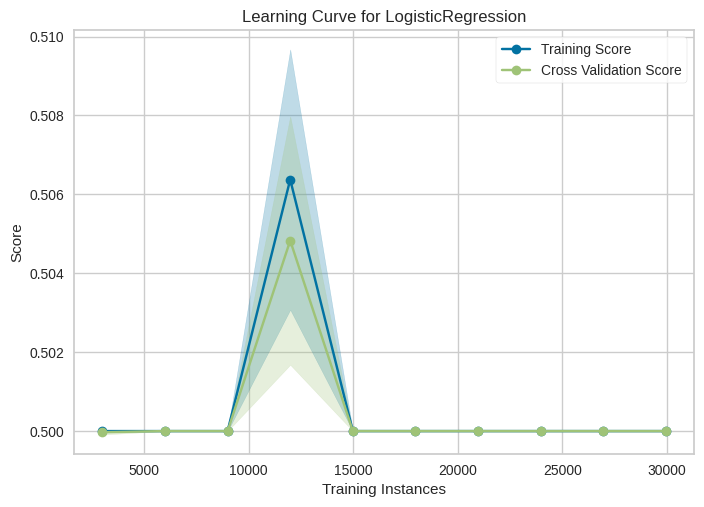

In [17]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    model_LogReg, scoring=metric, cv=StratifiedKFold(), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_test, y_test).show()

## Настройка гиперпараметров Gradient Boosting с помощью байесовсокой оптимизации

In [40]:
from bayes_opt_class import BayesOptimization

params = {"max_depth": (int, [2, 100]), 
          "min_samples_leaf": (int, [2, 100]),
          "min_samples_split": (int, [2, 100]), 
          "n_estimators": (int, [2, 100]),
          "ccp_alpha": (float, [1e-10, 1]),
          "learning_rate": (float, [1e-10, 1]),
          "max_features": (int, [1, 6]),
          "max_leaf_nodes": (int, [2, 100]),
          "min_impurity_decrease": (int, [1e-10, 1]),
          "tol": (int, [1e-10, 1])
}   

score, params = BayesOptimization(model_GB["gradientboostingclassifier"], params, n_iters=10, scoring="roc_auc").fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.9331646313252568
best params: {'max_depth': np.float64(8.0), 'min_samples_leaf': np.float64(16.0), 'min_samples_split': np.float64(34.0), 'n_estimators': np.float64(63.0), 'ccp_alpha': np.float64(0.6149876576832639), 'learning_rate': np.float64(0.04555874464629686), 'max_features': np.float64(3.0), 'max_leaf_nodes': np.float64(31.0), 'min_impurity_decrease': np.float64(0.0), 'tol': np.float64(0.0)}


### Посмотрим на результат

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth': np.int64(8.0), 
          'min_samples_leaf': np.int64(16.0), 
          'min_samples_split': np.int64(34.0), 
          'n_estimators': np.int64(63.0), 
        #   'ccp_alpha': np.float64(0.6149876576832639), 
        #   'learning_rate': np.float64(0.04555874464629686), 
          'max_features': np.int64(3.0), 
          'max_leaf_nodes': np.int64(31.0)}

pipline = make_pipeline(GradientBoostingClassifier(**params))
model_GB = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_GB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5916625583511044
 Cross validation score: 0.8643134290143688


### Анализ модели

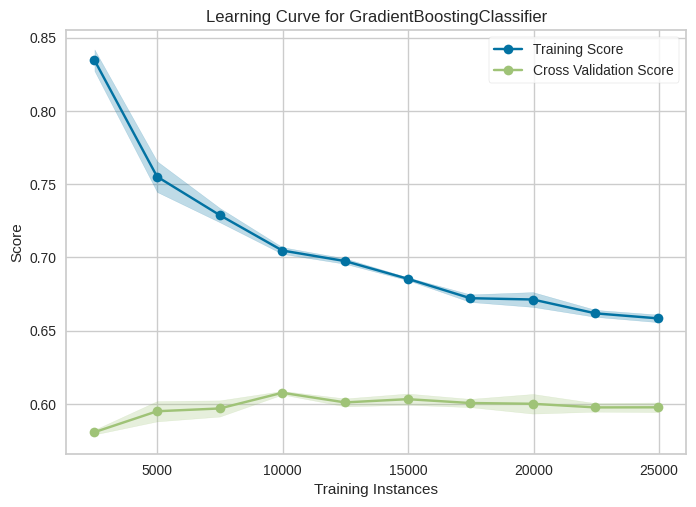

In [20]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    model_GB, scoring=metric, cv=StratifiedKFold(n_splits=3), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_test, y_test).show()

## Настройка гиперпараметров Ada Boosting с помощью optuna

In [41]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective(trial, X, y):
    # Определяем пространство параметров для оптимизации
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', 1, 10),
        'base_estimator__min_samples_split': trial.suggest_int('base_estimator__min_samples_split', 2, 20),
        'base_estimator__min_samples_leaf': trial.suggest_int('base_estimator__min_samples_leaf', 1, 10),
    }
    
    # Создаем базовый классификатор (дерево решений)
    base_estimator = DecisionTreeClassifier(
        max_depth=params['base_estimator__max_depth'],
        min_samples_split=params['base_estimator__min_samples_split'],
        min_samples_leaf=params['base_estimator__min_samples_leaf']
    )
    
    # Создаем AdaBoost с текущими параметрами
    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        random_state=42
    )
    
    # Используем кросс-валидацию для оценки качества
    scores = cross_val_score(
        model, X, y, 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Возвращаем средний ROC-AUC по фолдам
    return scores.mean()

# Оптимизация с Optuna
def optimize_adaboost(X, y, n_trials=100):
    # Создаем study и запускаем оптимизацию
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    # Выводим лучшие параметры
    print("Best trial:")
    trial = study.best_trial
    print(f"  ROC-AUC: {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study.best_params

best_params = optimize_adaboost(X, y, n_trials=100)

/home/kabantsov/python_venv/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-06 18:54:52,034] A new study created in memory with name: no-name-8793353d-844b-4507-924f-fc1b40b7b63b
[I 2025-04-06 18:57:01,791] Trial 0 finished with value: 0.827051211230715 and parameters: {'n_estimators': 116, 'learning_rate': 0.19550532066327175, 'base_estimator__max_depth': 7, 'base_estimator__min_samples_split': 3, 'base_estimator__min_samples_leaf': 8}. Best is trial 0 with value: 0.827051211230715.
[W 2025-04-06 18:59:59,083] Trial 1 failed with parameters: {'n_estimators': 498, 'learning_rate': 0.08169627155371251, 'base_estimator__max_depth': 4, 'base_estimator__min_samples_split': 11, 'base_estimator__min_samples_leaf': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent ca

KeyboardInterrupt: 

## Kaggle
Так как данные взяты с соревнования kaggle, то я пользуюсь возможностью проверки моделей на абсолютно новых для них данных и оценкой которой даёт система проверки kaggle:
1. **Decision Tree** - 0.498
2. **AdaBoosting** - 0.4045
3. **GaussianNB** - 0.496
4. **Logistic Regression** - 0.592
5. **Random Forest** - 0.473
6. **Gradient Boosting** - 0.497
7. **KNN** - 0.518
8. **Neural Network** - 0.606

In [27]:
# Функция для отправки результатов работы модели на Kaggle
def try_kaggle(model, X):
    probs = model.predict_proba(X)
    ans = []
    for prob in probs:
        ans.append(prob[1])

    out_pd = pd.DataFrame({
        "Id": [i for i in range(1, len(ans) + 1)],
        "Probability": ans
    })
    out_pd.to_csv("out.csv", index=False)

In [38]:
data_test = pd.read_csv("data/cs-test.csv", delimiter=',', index_col=0)
X_test_test = data_test[data_test.columns[1:]].interpolate()
scaled_X_test_test = scaler.fit_transform(X_test_test)
try_kaggle(model_GB, scaled_X_test_test)